In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve

# Helper methods

In [2]:
def save(path):
    plt.savefig('../../images' + path)

In [3]:
df  = pd.read_csv("../input/stroke-dataset/stroke.csv")
# df  = pd.read_csv("../input/stroke-dataset/stroke_subset.csv")

df = df.drop('id',axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(3), object(5)
memory usage: 3.6+ MB


# Data Exploration

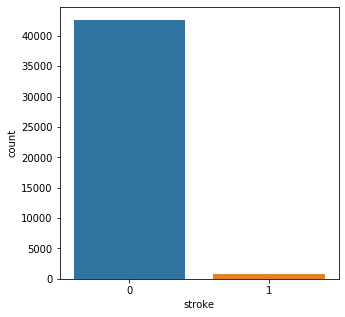

In [4]:
plt.figure(figsize=(5,5))
sns.countplot(x='stroke',data=df)
save('/building_ann/stroke_countplot.png')

In [5]:
df.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.272169,0.250188,0.237627,0.358897,0.156049
hypertension,0.272169,1.000000,0.119777,0.160211,0.161225,0.075332
heart_disease,0.250188,0.119777,1.000000,0.146938,0.057677,0.113763
avg_glucose_level,0.237627,0.160211,0.146938,1.000000,0.191295,0.078917
bmi,0.358897,0.161225,0.057677,0.191295,1.000000,0.020285
stroke,0.156049,0.075332,0.113763,0.078917,0.020285,1.000000


In [6]:
neg, pos = np.bincount(df['stroke'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 43400
    Positive: 783 (1.80% of total)



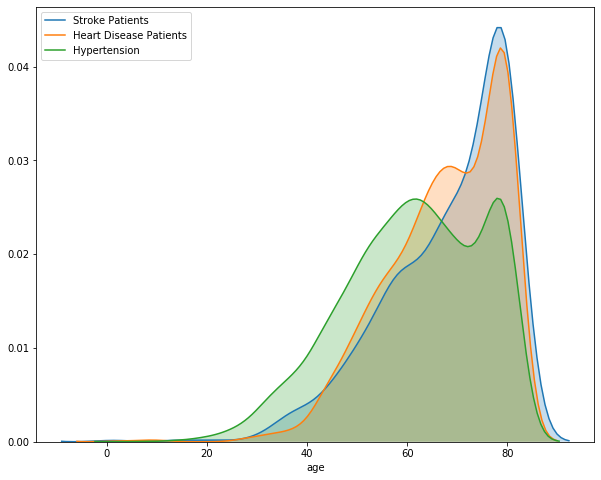

In [75]:
plt.figure(figsize=(10,8))
sns.distplot(df.loc[df['stroke'] == 1]['age'], label='Stroke Patients', kde_kws={"shade": True},hist=False, bins =20)
sns.distplot(df.loc[df['heart_disease'] == 1]['age'], label='Heart Disease Patients', kde_kws={"shade": True},hist=False, bins =20)
sns.distplot(df.loc[df['hypertension'] == 1]['age'], label='Hypertension', kde_kws={"shade": True},hist=False, bins =20)
plt.legend()
save('/building_ann/stroke_age_distplot.png')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
63,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
81,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
141,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
257,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
264,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
43148,25110,Female,56.0,0,0,Yes,Private,Rural,83.27,32.9,smokes,1
43268,5392,Male,69.0,0,0,Yes,Self-employed,Rural,97.36,28.0,NaN,1
43304,35057,Female,80.0,0,0,Yes,Self-employed,Urban,75.91,26.7,never smoked,1
43318,64109,Male,62.0,1,1,Yes,Private,Rural,77.97,31.5,formerly smoked,1


0.01804147465437788

In [9]:
df['gender'].value_counts()

Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

In [10]:
df.iloc[95]


gender                          Male
age                               34
hypertension                       0
heart_disease                      1
ever_married                     Yes
work_type                    Private
Residence_type                 Urban
avg_glucose_level             106.23
bmi                              NaN
smoking_status       formerly smoked
stroke                             0
Name: 95, dtype: object

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [12]:
# def fill_smoking_status(smoking_status):
#     if pd.isnull(smoking_status):
#         return np.nan
#     elif smoking_status=='never smoked':
#         return 0
#     elif smoking_status=='formerly smoked':
#         return 1
#     else: 
#         return 3
# df['smoking_status'] = df.apply(lambda x : fill_smoking_status(x['smoking_status']), axis=1)



# plt.figure(figsize=(9,9))
# sns.heatmap(df.corr(),annot=True,cmap='viridis')
# plt.ylim(9, 0)
# # plt.xlim(0, 1)

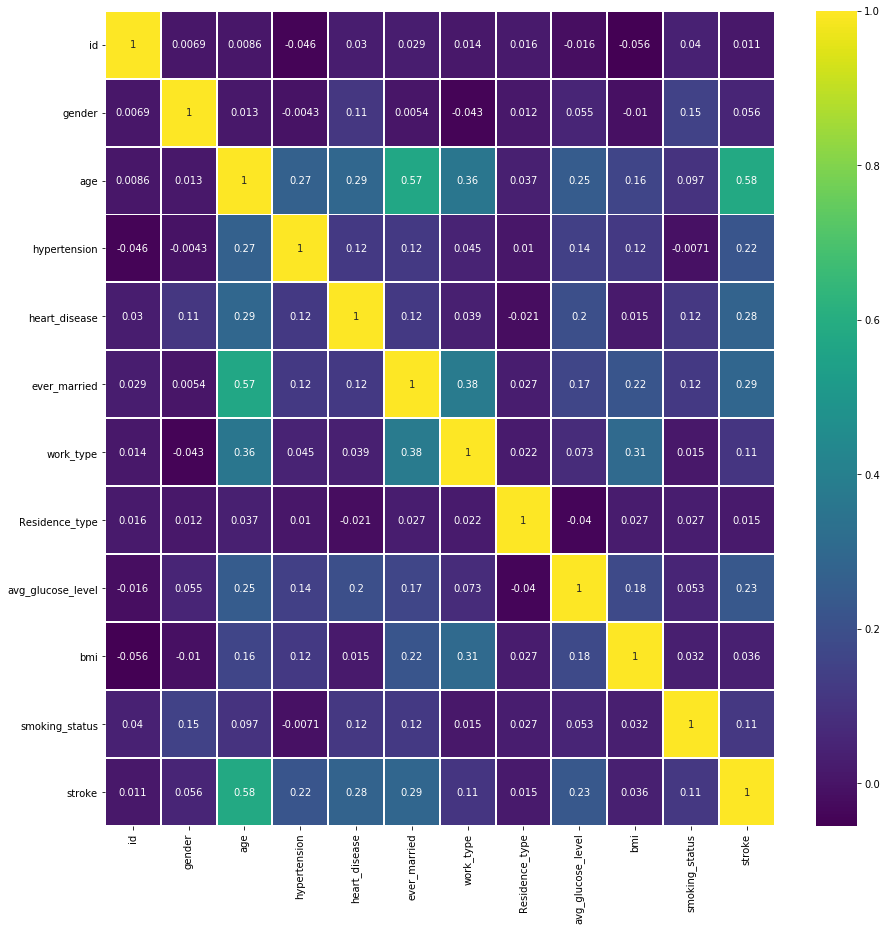

In [61]:
def fill_smoking_status(smoking_status):
    if pd.isnull(smoking_status):
        return np.nan
    elif smoking_status=='never smoked':
        return 0
    elif smoking_status=='formerly smoked':
        return 1
    else: 
        return 1
def fill_work_type(work_type):
    if work_type == 'children':
        return 0
    elif work_type == 'Never_worked':
        return 1
    elif work_type == 'Self-employed':
        return 2
    elif work_type == 'Private':
        return 3
    else: 
        return 4
df_hm = pd.read_csv("../input/stroke-dataset/stroke_subset.csv")
df_hm['smoking_status'] = df_hm.apply(lambda x : fill_smoking_status(x['smoking_status']), axis=1)
df_hm['ever_married'] = df_hm.apply(lambda x : 1 if x['ever_married']=='Yes' else 0, axis =1)
df_hm['Residence_type'] = df_hm.apply(lambda x : 1 if x['Residence_type']=='Urban' else 0, axis =1)
df_hm['work_type'] = df_hm.apply(lambda x : fill_work_type(x['work_type']), axis =1)
df_hm['gender'] = df_hm.apply(lambda x : 1 if x['gender']=='Male' else 0, axis =1)

plt.figure(figsize=(15,15))
sns.heatmap(df_hm.corr(),annot=True,cmap='viridis', linewidth=1)
plt.ylim(12, 0)
save('/building_ann/heatmap.png')

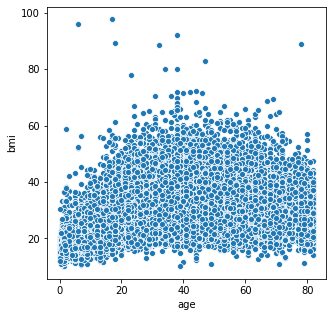

In [14]:
plt.figure(figsize=(5,5))
sns.scatterplot(x='age',y='bmi',data=df)
save('/building_ann/age_bmi_scatterplot.png')

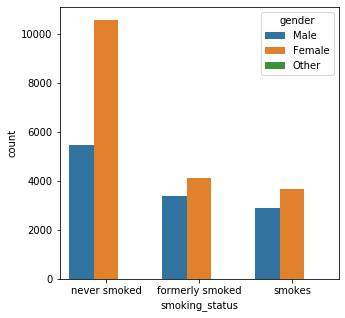

In [64]:
plt.figure(figsize=(5,5))
df = pd.read_csv("../input/stroke-dataset/stroke.csv")
sns.countplot(x='smoking_status',data=df,hue='gender')
save('/building_ann/smoking_scatterplot.png')

In [73]:
len(df[df['stroke'] == 1 ])/len(df)

0.01804147465437788

In [74]:
df = pd.read_csv("../input/stroke-dataset/stroke.csv")
stroke_y = df[df['stroke'] == 1 ].groupby("smoking_status").count()['stroke']
stroke_n = df[df['stroke'] == 0 ].groupby("smoking_status").count()['stroke']
print(stroke_y/(stroke_y + stroke_n))

smoking_status
formerly smoked    0.029494
never smoked       0.017691
smokes             0.020268
Name: stroke, dtype: float64


In [18]:
np.bincount(df.apply(lambda x : 1 if x['gender']=='Male' else 0, axis =1))

array([25676, 17724], dtype=int64)

In [21]:
# def fill_smoking_status(smoking_status, isMale):
#     if smoking_status=='never smoked':
#         return 0
#     else: 
#         return isMale if pd.isnull(smoking_status) else 1
# df['smoking_status'] = df.apply(lambda x : fill_smoking_status(x['smoking_status'], x['Male']), axis=1)



# plt.figure(figsize=(9,9))
# sns.heatmap(df.corr(),annot=True,cmap='viridis')
# plt.ylim(9, 0)
# # plt.xlim(0, 1)

# Missing Data

In [22]:
df.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [23]:
df.isnull().sum()
df['gender'] = df['gender'].replace(["Other"], "Male")
df['gender'].value_counts()
gender_dummies = pd.get_dummies(df['gender'],drop_first=True)
df = pd.concat([df.drop('gender',axis=1),gender_dummies],axis=1)


work_type_dummies = pd.get_dummies(df['work_type'],drop_first=True)
df = pd.concat([df.drop('work_type',axis=1),work_type_dummies],axis=1)

married_dummies = pd.get_dummies(df['ever_married'],drop_first=True)
df = pd.concat([df.drop('ever_married',axis=1),married_dummies],axis=1)
df = df.rename(columns={'Yes': 'Married'})

residence_dummies = pd.get_dummies(df['Residence_type'],drop_first=True)
df = pd.concat([df.drop('Residence_type',axis=1),residence_dummies],axis=1)

bmi_avg= df.groupby('age').mean()['bmi']
df['bmi'] = df.apply(lambda x : bmi_avg[x['age']] if np.isnan(x['bmi']) else x['bmi'], axis =1)

df

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,Male,Never_worked,Private,Self-employed,children,Married,Urban
0,30669,3.0,0,0,95.12,18.0,NaN,0,1,0,0,0,1,0,0
1,30468,58.0,1,0,87.96,39.2,never smoked,0,1,0,1,0,0,1,1
2,16523,8.0,0,0,110.89,17.6,NaN,0,0,0,1,0,0,0,1
3,56543,70.0,0,0,69.04,35.9,formerly smoked,0,0,0,1,0,0,1,0
4,46136,14.0,0,0,161.28,19.1,NaN,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,10.0,0,0,58.64,20.4,never smoked,0,0,0,0,0,1,0,1
43396,5450,56.0,0,0,213.61,55.4,formerly smoked,0,0,0,0,0,0,1,1
43397,28375,82.0,1,0,91.94,28.9,formerly smoked,0,0,0,1,0,0,1,1
43398,27973,40.0,0,0,99.16,33.2,never smoked,0,1,0,1,0,0,1,1


In [24]:

df.isnull().sum()

id                       0
age                      0
hypertension             0
heart_disease            0
avg_glucose_level        0
bmi                      0
smoking_status       13292
stroke                   0
Male                     0
Never_worked             0
Private                  0
Self-employed            0
children                 0
Married                  0
Urban                    0
dtype: int64

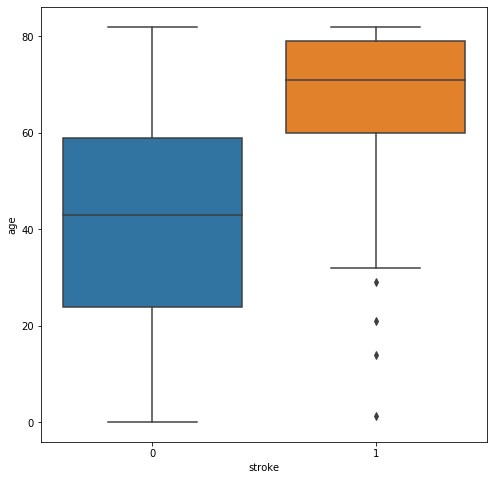

In [26]:
plt.figure(figsize=(8,8))
sns.boxplot(x='stroke',y='age',data=df)

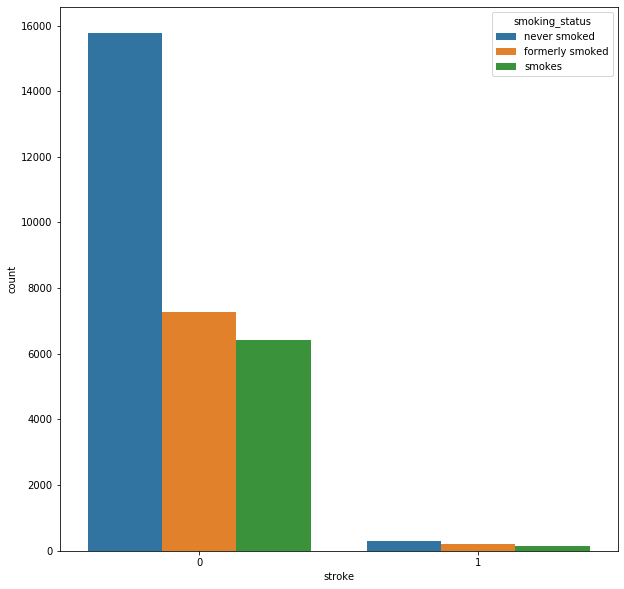

In [27]:
# sorted(df['smoking_status'].unique())
plt.figure(figsize=(10,10))
sns.countplot(x='stroke',data=df,hue='smoking_status')

In [28]:
df.corr()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Male,Never_worked,Private,Self-employed,children,Married,Urban
id,1.000000,0.012760,0.006571,0.009234,0.024634,0.016376,0.002976,0.001680,0.003553,0.009300,0.008338,-0.021144,0.010217,0.000120
age,0.012760,1.000000,0.272169,0.250188,0.237627,0.360307,0.156049,-0.027768,-0.069509,0.143657,0.326913,-0.641240,0.693070,0.001299
hypertension,0.006571,0.272169,1.000000,0.119777,0.160211,0.159249,0.075332,0.023902,-0.019319,0.007236,0.100243,-0.130171,0.176575,-0.003124
heart_disease,0.009234,0.250188,0.119777,1.000000,0.146938,0.058688,0.113763,0.082270,-0.014292,-0.006327,0.099342,-0.089559,0.128833,-0.002743
avg_glucose_level,0.024634,0.237627,0.160211,0.146938,1.000000,0.189386,0.078917,0.035695,-0.014516,0.008048,0.080246,-0.114174,0.153607,0.000014
bmi,0.016376,0.360307,0.159249,0.058688,0.189386,1.000000,0.022109,-0.020492,-0.021931,0.203891,0.083785,-0.462871,0.344648,-0.003537
stroke,0.002976,0.156049,0.075332,0.113763,0.078917,0.022109,1.000000,0.011281,-0.008674,-0.002464,0.061195,-0.054115,0.071920,0.002247
Male,0.001680,-0.027768,0.023902,0.082270,0.035695,-0.020492,0.011281,1.000000,0.002700,-0.052028,-0.002953,0.089127,-0.031183,0.001558
Never_worked,0.003553,-0.069509,-0.019319,-0.014292,-0.014516,-0.021931,-0.008674,0.002700,1.000000,-0.074011,-0.027566,-0.026017,-0.080734,0.003089
Private,0.009300,0.143657,0.007236,-0.006327,0.008048,0.203891,-0.002464,-0.052028,-0.074011,1.000000,-0.498211,-0.470203,0.158857,0.006050


In [29]:
plt.figure(figsize=(20,5))
df.corr()['age'].sort_values().drop('age')

children            -0.641240
Never_worked        -0.069509
Male                -0.027768
Urban                0.001299
id                   0.012760
Private              0.143657
stroke               0.156049
avg_glucose_level    0.237627
heart_disease        0.250188
hypertension         0.272169
Self-employed        0.326913
bmi                  0.360307
Married              0.693070
Name: age, dtype: float64

<Figure size 1440x360 with 0 Axes>

In [30]:
df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,Male,Never_worked,Private,Self-employed,children,Married,Urban
0,30669,3.0,0,0,95.12,18.0,NaN,0,1,0,0,0,1,0,0
1,30468,58.0,1,0,87.96,39.2,never smoked,0,1,0,1,0,0,1,1
2,16523,8.0,0,0,110.89,17.6,NaN,0,0,0,1,0,0,0,1
3,56543,70.0,0,0,69.04,35.9,formerly smoked,0,0,0,1,0,0,1,0
4,46136,14.0,0,0,161.28,19.1,NaN,0,1,1,0,0,0,0,0


In [31]:
len(df)

43400

In [32]:
df.isnull().sum()
df[np.isnan(df['bmi'])]

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,Male,Never_worked,Private,Self-employed,children,Married,Urban


In [33]:
age_1 = df[df['stroke']==1].groupby("smoking_status").count()['stroke']
age_0 = df[df['stroke']==0].groupby("smoking_status").count()['stroke']


In [34]:
 (age_1/(age_1 + age_0))

smoking_status
formerly smoked    0.029494
never smoked       0.017691
smokes             0.020268
Name: stroke, dtype: float64

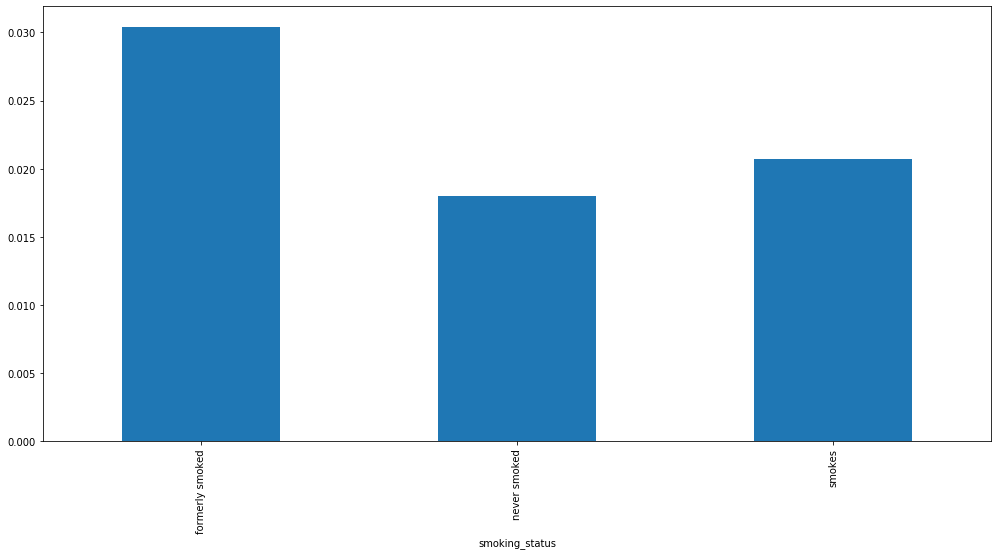

In [35]:
plt.figure(figsize=(17,8))
age_len = age_1/age_0
age_len.plot(kind = 'bar')

In [36]:
len(df.columns)

15

## Split Data

In [37]:
from sklearn.model_selection import train_test_split
df=df.sample(frac=1)

In [38]:
X = df.drop('stroke', axis =1).values
X

array([[45373, 17.0, 0, ..., 0, 0, 0],
       [28024, 49.0, 0, ..., 0, 1, 0],
       [3531, 41.0, 0, ..., 0, 1, 0],
       ...,
       [61828, 42.0, 0, ..., 0, 1, 0],
       [25916, 53.0, 0, ..., 0, 1, 1],
       [7363, 46.0, 0, ..., 0, 1, 1]], dtype=object)

In [39]:
y = df['stroke'].values
y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ValueError: could not convert string to float: 'never smoked'

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

time = datetime.now().strftime("%Y-%m-%d--%H%M")
logdir = 'logs\\hparam_tuning'
# board = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images = True, 
#                     update_freq='epoch', profile_batch=2, embeddings_freq=1)

In [ ]:

model = Sequential()
# input layer
model.add(Dense(39,  activation='relu'))
model.add(Dropout(0.1))

# hidden layer
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.1))

# hidden layer
model.add(Dense(18, activation='relu'))
model.add(Dropout(0.1))

# hidden layer
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy'] )

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

weights = {0:1, 1:54}
model.fit(x=X_train, 
          y=y_train, 
          epochs=400,
          class_weight=weights,
          batch_size=2048,
          validation_data=(X_test, y_test), 
          verbose=1,
          callbacks = [early_stop]
          )


In [ ]:
# from tensorboard.plugins.hparams import api as hp
# HP_NUM_UNITS_L1 = hp.HParam('num_units_l1', hp.Discrete([16, 32]))
# HP_NUM_UNITS_L2 = hp.HParam('num_units_l2', hp.Discrete([8,4]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

# METRIC_ACCURACY = 'accuracy'

# with tf.summary.create_file_writer('logs\\hparam_tuning').as_default():
#     hp.hparams_config(
#         hparams=[HP_NUM_UNITS_L1,HP_NUM_UNITS_L2, HP_DROPOUT, HP_OPTIMIZER],
#         metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
#   )

# def train_test_model(hparams):
#     model = Sequential()
#     # input layer
#     model.add(Dense(hparams[HP_NUM_UNITS_L1],  activation='relu'))
#     model.add(Dropout(hparams[HP_DROPOUT]))

#     # hidden layer
#     model.add(Dense(hparams[HP_NUM_UNITS_L2], activation='relu'))
#     model.add(Dropout(hparams[HP_DROPOUT]))
    
#     model.add(Dense(8, activation='relu'))
#     model.add(Dropout(hparams[HP_DROPOUT]))
#     # output layer
#     model.add(Dense(units=1,activation='sigmoid'))

#     # Compile model
#     model.compile(loss='binary_crossentropy', optimizer=hparams[HP_OPTIMIZER],  metrics=['accuracy'])
    
#     model.fit(x=X_train, 
#           y=y_train, 
#           epochs=400,
#           validation_data=(X_test, y_test), 
#           verbose=1,
#           callbacks = [early_stop,
#                        tf.keras.callbacks.TensorBoard(logdir),  # log metrics
#                         hp.KerasCallback(logdir, hparams)]
#           )
    
#     _, accuracy = model.evaluate(X_test, y_test)
    
#     return accuracy

# def run(run_dir, hparams):
#     with tf.summary.create_file_writer(run_dir).as_default():
#         hp.hparams(hparams)  # record the values used in this trial
#         accuracy = train_test_model(hparams)
#         tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

# session_num = 0

# for num_units_l1 in HP_NUM_UNITS_L1.domain.values:
#     for num_units_l2 in HP_NUM_UNITS_L2.domain.values:
#         for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
#             for optimizer in HP_OPTIMIZER.domain.values:
#               hparams = {
#                   HP_NUM_UNITS_L1: num_units_l1,
#                   HP_NUM_UNITS_L2: num_units_l2,
#                   HP_DROPOUT: dropout_rate,
#                   HP_OPTIMIZER: optimizer,
#               }
#               run_name = "run-%d" % session_num
#               print('--- Starting trial: %s' % run_name)
#               print({h.name: hparams[h] for h in hparams})
#               run('logs\\hparam_tuning' + run_name, hparams)
#               session_num += 1

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:

predictions = model.predict_classes(X_test)
print(classification_report(y_test,predictions))

In [ ]:
# part of this code is taken from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
#   plt.ylabel('Actual label')
#   plt.xlabel('Predicted label')
  plt.ylim(2, 0)
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))
plot_cm(y_test,predictions)    

In [ ]:
roc_curve(y_test,predictions)

In [ ]:
len(predictions)

In [ ]:
row = 300
patient = df.drop('stroke', axis = 1).iloc[row]
patient

In [ ]:
patient = scaler.transform(patient.values.reshape(1,13))
patient

In [ ]:
model.predict_classes(patient)[0][0]

In [ ]:
for row in range (0,10):
    patient = df.drop('stroke', axis = 1).iloc[row]
    patient = scaler.transform(patient.values.reshape(1,13))
    prediction = (model.predict_classes(patient))[0][0]
    print ("Predicted:{} Actual:{}".format(prediction,df.iloc[row]['stroke']))